In [1]:
import yaml
import numpy as np
import learners
import dataloaders
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt

In [2]:
def softmax(data):
    e = np.exp(data)
    return e / np.sum(e, axis=1, keepdims=True)

In [3]:
with open('acc_table.pkl', 'rb') as f:
    results = pickle.load(f)
    
for checkpoint_id in results:
    for eval_id in range(len(results[checkpoint_id])):
        acc = results[checkpoint_id][eval_id][0]
        true = results[checkpoint_id][eval_id][1]
        pred = results[checkpoint_id][eval_id][2]
        logits = results[checkpoint_id][eval_id][3]   # (N, C)
        prob = softmax(logits)
        results[checkpoint_id][eval_id] = (acc, true, pred, prob)

for checkpoint_id in results:
    results[checkpoint_id] = {index + 1: value for index, value in enumerate(results[checkpoint_id])}


In [4]:
# current checkpoint task_id | eval task_id | acc, trye, pred, logits
print(results[10][1][1][2])
print(results[10][1][2][2])

for i in range(10):
    print(f"{results[10][1][3][2][i]:.3f}", end=" ")


8
8
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 

In [5]:
def draw(check_task_id, data):
    x = []
    ys = []

    x = [index for index in range(check_task_id, len(data))]

    for checkpoint_index in range(check_task_id, len(data) + 1):
        acc = data[checkpoint_index][check_task_id][0]
        true = data[checkpoint_index][check_task_id][1]
        pred = data[checkpoint_index][check_task_id][2]
        prob = data[checkpoint_index][check_task_id][3]
        
        true = np.array(true)
        
        incurrect = {key: 0 for key in np.unique(true)}
        for i in range(len(true)):
            if true[i] != pred[i]:
                incurrect[true[i]] += 1
        
        incurrect = [incurrect[key] for key in incurrect]
        
        ys.append(incurrect)
        
    ys = np.array(ys).T
    print(ys.shape)
        
    plt.figure()
    for acc in ys:
        plt.plot(x, acc)
    plt.show()  

(9, 10)


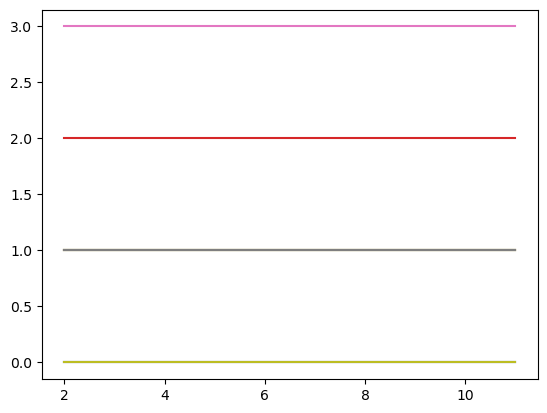

(9, 9)


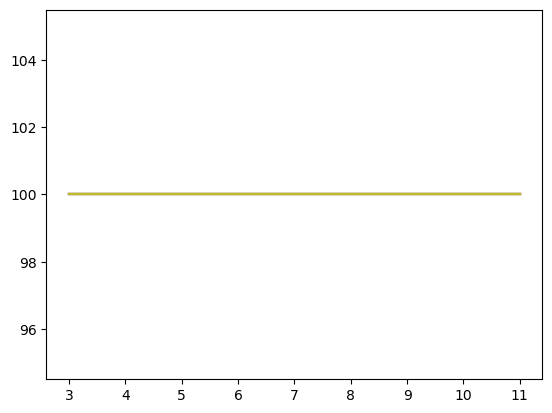

(9, 8)


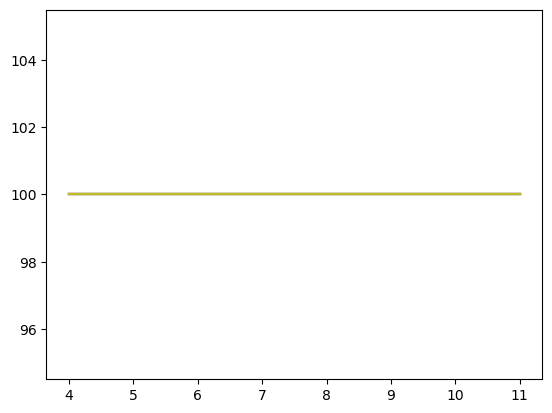

(9, 7)


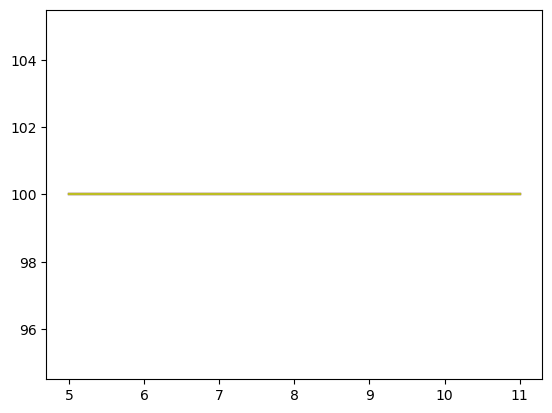

(9, 6)


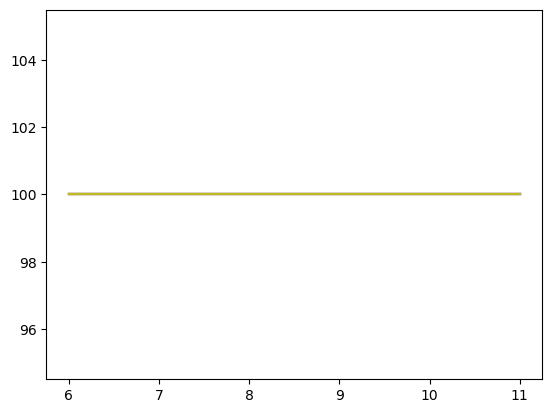

(9, 5)


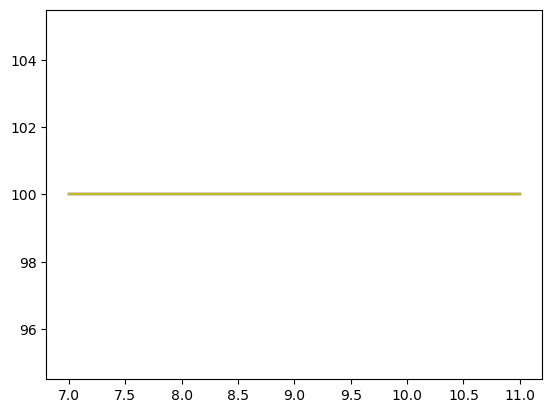

(9, 4)


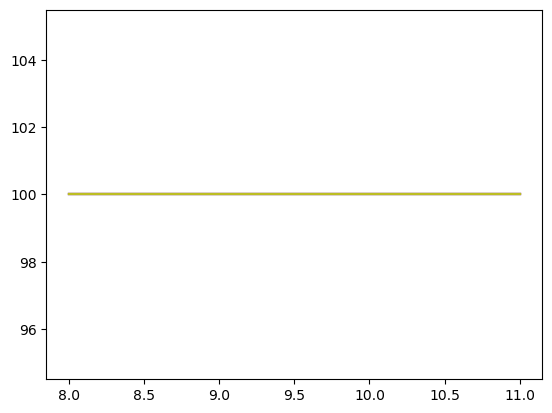

(9, 3)


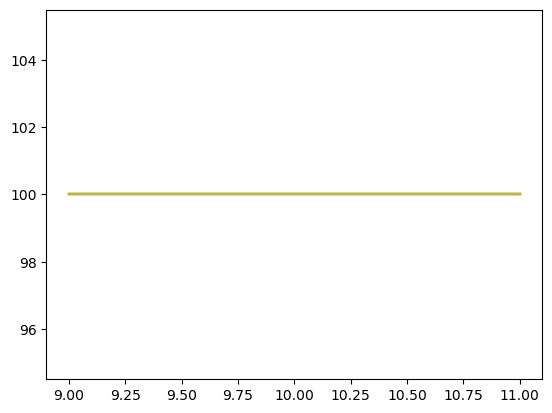

(9, 2)


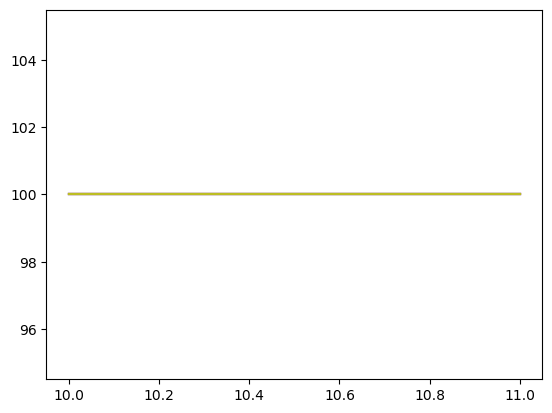

(9, 1)


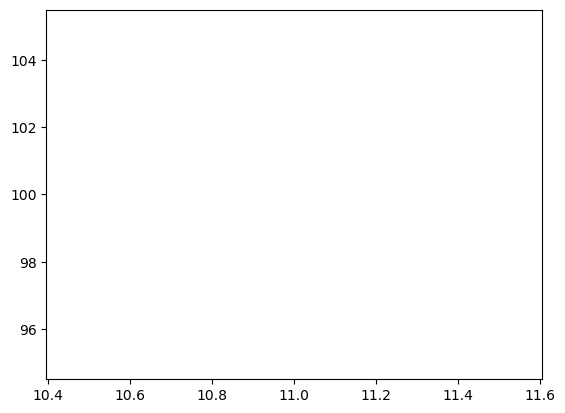

In [6]:
for i in range(1, 11):
    draw(i, results)

In [7]:
# check_task_id = 2

# x = []
# ys = []

# x = [index + 1 for index in range(check_task_id, len(results) + 1)]

# for checkpoint_index in range(check_task_id, len(results) + 1):
#     acc = results[checkpoint_index][check_task_id][0]
#     true = results[checkpoint_index][check_task_id][1]
#     pred = results[checkpoint_index][check_task_id][2]
#     prob = results[checkpoint_index][check_task_id][3]
    
#     true = np.array(true)
    
#     incurrect = {key: 0 for key in np.unique(true)}
#     for i in range(len(true)):
#         if true[i] != pred[i]:
#             incurrect[true[i]] += 1
    
#     incurrect = [incurrect[key] for key in incurrect]
    
#     ys.append(incurrect)
    
# ys = np.array(ys).T
    
# plt.figure()
# for acc in ys:
#     plt.plot(x, acc)
# plt.show()  